In [15]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

# llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
llm = ChatGroq(model="qwen-qwq-32b")

In [16]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [17]:
tools

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

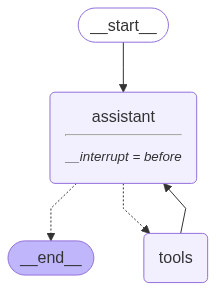

In [18]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [19]:
initial_input = {"messages": HumanMessage(content="Multiply 5 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3


In [20]:
state = graph.get_state(thread)
state.next

('assistant',)

In [21]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================


In [22]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================


In [23]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 10 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 10 and 3
================================ Human Message =================================

Multiply 10 and 3
================================== Ai Message ==================================


In [24]:
initial_input = {"messages": HumanMessage(content="Multiply 5 and 3")}

# Thread
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3


In [25]:
graph.update_state(
    thread,
    {
        "messages": [HumanMessage(content="ohh no, i want to multiply 40 and 4.")]
    }
)

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f035716-f6e0-690a-8001-63e4a04a1edc'}}

In [26]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================ Human Message =================================

ohh no, i want to multiply 40 and 4.


In [27]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

ohh no, i want to multiply 40 and 4.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_j02b)
 Call ID: call_j02b
  Args:
    a: 40
    b: 4
================================= Tool Message =================================
Name: multiply

160


In [28]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

160
================================== Ai Message ==================================

The result of multiplying 40 by 4 is **160**. Let me know if you need further assistance!


In [29]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='a09c301d-8fb6-4402-97e4-b884025aa65f'), HumanMessage(content='ohh no, i want to multiply 40 and 4.', additional_kwargs={}, response_metadata={}, id='0542e20c-e740-4724-ad6c-ada45cdaf68c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j02b', 'function': {'arguments': '{"a": 40, "b": 4}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 211, 'prompt_tokens': 376, 'total_tokens': 587, 'completion_time': 0.478416807, 'prompt_time': 0.021547619, 'queue_time': 0.269946931, 'total_time': 0.499964426}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--523d7821-9c6f-408b-ae42-f7ceacfe7db8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 40, 'b': 4}, 'id': 'call_j02b', 'type': 'tool_call'}], usage_metadata={'input_tokens'